In [26]:
!ls

drive  sample_data


In [50]:
import torch
from torch import nn
import numpy as np
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

import os
%matplotlib inline

In [51]:
# 0. Patch Embedding Variables
p = 16 # patch
w = 224 # width
h = 224 # height
c = 3 # channel
b = 10 # batch

In [7]:
# 0. 이미지 불러오기 (Using Numpy)
# 변환할 이미지 목록 불러오기
image_path = 'drive/MyDrive/Vision-Transformer/dataset/'

img_list = os.listdir(image_path) #디렉토리 내 모든 파일 불러오기
img_list_jpg = [img for img in img_list if img.endswith(".jpeg")] #지정된 확장자만 필터링

print ("img_list_jpg: {}".format(img_list_jpg))

img_list_np = []

for i in img_list_jpg:
    img = Image.open(image_path + i)
    resized_ = img.resize((w,h))
    img_array = np.array(resized_)
    img_list_np.append(img_array)
    print(i, " 추가 완료 - 구조:", img_array.shape) # 불러온 이미지의 차원 확인 (세로X가로X색)
    #print(img_array.T.shape) #축변경 (색X가로X세로)


img_list_jpg: ['001.jpeg', '003.jpeg', '002.jpeg', '004.jpeg', '005.jpeg', '006.jpeg', '007.jpeg', '008.jpeg', '009.jpeg', '010.jpeg']
001.jpeg  추가 완료 - 구조: (224, 224, 3)
003.jpeg  추가 완료 - 구조: (224, 224, 3)
002.jpeg  추가 완료 - 구조: (224, 224, 3)
004.jpeg  추가 완료 - 구조: (224, 224, 3)
005.jpeg  추가 완료 - 구조: (224, 224, 3)
006.jpeg  추가 완료 - 구조: (224, 224, 3)
007.jpeg  추가 완료 - 구조: (224, 224, 3)
008.jpeg  추가 완료 - 구조: (224, 224, 3)
009.jpeg  추가 완료 - 구조: (224, 224, 3)
010.jpeg  추가 완료 - 구조: (224, 224, 3)


In [52]:
# 0. 이미지 불러오기 (Using torchvision)
import torchvision.transforms as transforms

image_path = 'drive/MyDrive/Vision-Transformer/dataset/'

img_list = os.listdir(image_path) #디렉토리 내 모든 파일 불러오기
img_list_jpg = [img for img in img_list if img.endswith(".jpeg")] #지정된 확장자만 필터링

output = []
for i in img_list_jpg:
  PIL_tensor = transforms.ToTensor()
  img = Image.open(image_path + i)
  img = ImageOps.exif_transpose(img) # EXIF로 인해서 이미지가 회전되는 현상을 방지
  resized_ = img.resize((w,h))
  Image_tensor = PIL_tensor(resized_)
  output.append(Image_tensor)
  print(i, "Added", Image_tensor.shape)
img_all = torch.stack(output)

001.jpeg Added torch.Size([3, 224, 224])
003.jpeg Added torch.Size([3, 224, 224])
002.jpeg Added torch.Size([3, 224, 224])
004.jpeg Added torch.Size([3, 224, 224])
005.jpeg Added torch.Size([3, 224, 224])
006.jpeg Added torch.Size([3, 224, 224])
007.jpeg Added torch.Size([3, 224, 224])
008.jpeg Added torch.Size([3, 224, 224])
009.jpeg Added torch.Size([3, 224, 224])
010.jpeg Added torch.Size([3, 224, 224])


## Patch Embedding
- 이미지를 받았을때 Linear Projection으로 변경
- Positional Embedding까지 추가


In [62]:
# 예시 코드
# https://velog.io/@pre_f_86/PyTorch%EB%A1%9C-%EC%9D%B4%EB%AF%B8%EC%A7%80-%ED%8C%A8%EC%B9%98%EB%A1%9C-%EB%A7%8C%EB%93%A4%EA%B8%B0
b = 2
c = 3 # 채널의 수
p = 2 # 패치의 크기
h = 4 # 이미지의 높이
w = 4 # 이미지의 너비
img_test = torch.tensor(list(range(b*c*h*w)),dtype=torch.float32).reshape(b,c,h,w)+1 # 이미지를 c,h,w 형식으로 선언
img_test
# 내가 자른 텐서가 잘 잘렸는지 확인


tensor([[[[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]],

         [[17., 18., 19., 20.],
          [21., 22., 23., 24.],
          [25., 26., 27., 28.],
          [29., 30., 31., 32.]],

         [[33., 34., 35., 36.],
          [37., 38., 39., 40.],
          [41., 42., 43., 44.],
          [45., 46., 47., 48.]]],


        [[[49., 50., 51., 52.],
          [53., 54., 55., 56.],
          [57., 58., 59., 60.],
          [61., 62., 63., 64.]],

         [[65., 66., 67., 68.],
          [69., 70., 71., 72.],
          [73., 74., 75., 76.],
          [77., 78., 79., 80.]],

         [[81., 82., 83., 84.],
          [85., 86., 87., 88.],
          [89., 90., 91., 92.],
          [93., 94., 95., 96.]]]])

Need to be
```
tensor([[[ 1.,  2.,  5.,  6.,  3.,  4.,  7.,  8.,  9., 10., 13., 14.],
         ... ])
```

In [65]:
n = w//p
patched_img = img_test.reshape(b,c,h//p,p,w//p,p) # 이미지 1개당 N*N개 패치가 나오고, 패치 하나의 이미지는 P*P*C
patched_img = patched_img.transpose(3,4)
patched_img = patched_img.transpose(1,3)
patched_img = patched_img.transpose(1,2)
patched_img = patched_img.reshape(b,n*n,p*p*c)
patched_img
# 이걸 Linear하게 변경을 한다면?

tensor([[[ 1.,  2.,  5.,  6., 17., 18., 21., 22., 33., 34., 37., 38.],
         [ 3.,  4.,  7.,  8., 19., 20., 23., 24., 35., 36., 39., 40.],
         [ 9., 10., 13., 14., 25., 26., 29., 30., 41., 42., 45., 46.],
         [11., 12., 15., 16., 27., 28., 31., 32., 43., 44., 47., 48.]],

        [[49., 50., 53., 54., 65., 66., 69., 70., 81., 82., 85., 86.],
         [51., 52., 55., 56., 67., 68., 71., 72., 83., 84., 87., 88.],
         [57., 58., 61., 62., 73., 74., 77., 78., 89., 90., 93., 94.],
         [59., 60., 63., 64., 75., 76., 79., 80., 91., 92., 95., 96.]]])

In [127]:
# 1. Patch Embedding
# 0. Patch Embedding Variables
p = 16 # patch
w = 224 # width
h = 224 # height
c = 3 # channel
b = 10 # batch
d = 1024

n = w//p
patched_img = img_all.view(b,c,h//p,p,w//p,p) # 이미지 1개당 N*N개 패치가 나오고, 패치 하나의 이미지는 P*P*C
patched_img = patched_img.transpose(3,4)
patched_img = patched_img.transpose(1,3)
patched_img = patched_img.transpose(1,2)
patched_img = patched_img.reshape(b,n*n,p*p*c)
patched_img.shape
## 이렇게 한다고 끝이 아닌듯함. 내가 원하는 대로 잘렸는지 확인이 필요함 (복원했을때 잘 보이게)
## nn.Conv2d로도 할 수 있는 듯함. 이걸로도 구현해보자

torch.Size([10, 196, 768])

In [140]:
# Trainable Linear Projection이 필요
# nn.Module로 구성
class PositionalEmbedding(nn.Module):
    def __init__(self):
        super(PositionalEmbedding, self).__init__()
        self.projection = nn.Linear(p*p*c, d)

    def patchify(self,img):
      # Divide to patch
      patched_img = img.view(b,c,h//p,p,w//p,p) # 이미지 1개당 N*N개 패치가 나오고, 패치 하나의 이미지는 P*P*C
      patched_img = patched_img.transpose(3,4)
      patched_img = patched_img.transpose(1,3)
      patched_img = patched_img.transpose(1,2)
      patched_img = patched_img.reshape(b,n*n,p*p*c)
      return patched_img

    def forward(self, x):
      patched_ = self.patchify(x)
      return self.projection(patched_)

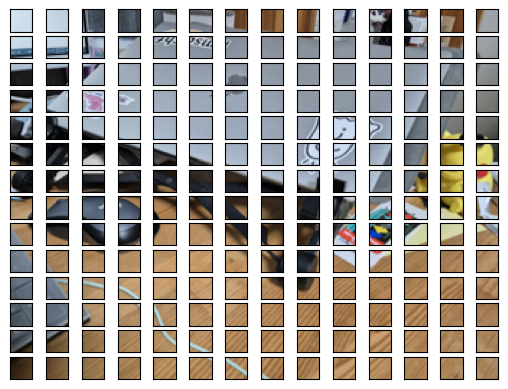

In [73]:
# Patch Debugging
fig = plt.figure() # rows*cols 행렬의 i번째 subplot 생성
rows = n
cols = n
i = 1

for data in patched_img:
  for patch in data:
    tmp = patch.view(c,p,p)
    # print(tmp.shape)
    to_img = transforms.ToPILImage()
    img_back = to_img(tmp)
    ax = fig.add_subplot(rows, cols, i)
    ax.imshow(img_back)
    ax.set_xticks([]), ax.set_yticks([])
    i += 1
  break
plt.show()

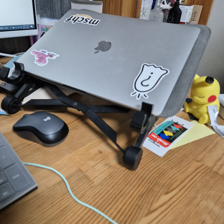

In [75]:
## For debug
## 근데 이렇게 분해하는 것 말고, 직접 tensor를 분해해야되는거 아닌가

t = img_all[0]
to_img = transforms.ToPILImage()
img = to_img(t)
img

## Position Embedding

In [111]:
patched_img

tensor([[[0.8196, 0.8196, 0.8157,  ..., 0.9098, 0.9059, 0.9059],
         [0.7843, 0.7804, 0.7765,  ..., 0.8824, 0.8784, 0.8784],
         [0.1294, 0.0275, 0.5216,  ..., 0.4314, 0.3647, 0.3804],
         ...,
         [0.6824, 0.6980, 0.7216,  ..., 0.3333, 0.3412, 0.3333],
         [0.7020, 0.7176, 0.6667,  ..., 0.3412, 0.3490, 0.3843],
         [0.6667, 0.6745, 0.6941,  ..., 0.3608, 0.3176, 0.3176]],

        [[0.4667, 0.3647, 0.4784,  ..., 0.6039, 0.6392, 0.6314],
         [0.4196, 0.4196, 0.4196,  ..., 0.7216, 0.5451, 0.3255],
         [0.3412, 0.3176, 0.2980,  ..., 0.6039, 0.6588, 0.6549],
         ...,
         [0.5843, 0.6000, 0.5961,  ..., 0.3098, 0.3216, 0.3373],
         [0.6275, 0.6235, 0.6039,  ..., 0.3098, 0.3098, 0.3176],
         [0.5176, 0.5137, 0.4941,  ..., 0.3373, 0.3608, 0.3765]],

        [[0.5725, 0.5843, 0.5765,  ..., 0.3686, 0.3922, 0.4000],
         [0.5176, 0.4941, 0.4941,  ..., 0.4667, 0.4627, 0.4784],
         [0.5412, 0.5412, 0.5451,  ..., 0.4275, 0.4314, 0.

In [141]:
# Patch 맨 뒤에다가 붙이는거 같은데
# 일단은 학습이 가능해야된다 (torch로 학습 가능한 변수 생성)
# x class도 학습이 가능해야된다. 맨앞에 들어가구
# 지금 shape는 torch.Size([10, 196, 768])
# x_class 는 1D 768인거 같구
# pos = (196+1)*768인거 같다
x_class = nn.Parameter(torch.randn(10,1,p*p*c))
pos_emb = nn.Parameter(torch.randn(10,197,p*p*c))
tuple_ = (x_class, patched_img)
with_class = torch.cat(tuple_, dim = 1)
print("with class embedding : ", with_class.shape)
with_class_pos = with_class + pos_emb # 이게 맞나? 그냥 더하는게?
print("with class & positional embedding : ", with_class_pos.shape)

with class embedding :  torch.Size([10, 197, 768])
with class & positional embedding :  torch.Size([10, 197, 768])
with class embedding :  torch.Size([10, 197, 768])
with class & positional embedding :  torch.Size([10, 197, 768])


tensor([[[ 1.6510, -0.6282, -0.3011,  ..., -0.5826,  0.6119, -0.0178],
         [ 0.4029,  0.7084, -0.2827,  ..., -0.5449,  0.8651,  0.6521],
         [ 1.6748,  0.9626, -0.7014,  ..., -0.1621, -0.7369,  0.8116],
         ...,
         [ 0.3198,  0.1689,  0.7381,  ...,  0.2828, -0.0524, -0.4836],
         [ 1.4806,  0.5495,  0.3138,  ..., -0.0778,  0.1786, -0.6467],
         [ 0.0206,  0.4420,  1.0358,  ...,  0.0142,  0.8169,  0.7664]],

        [[ 1.1630, -0.2093,  0.5763,  ...,  1.3707,  0.8631,  1.3699],
         [ 0.8174,  0.2126,  1.1916,  ..., -0.2008,  0.3731, -0.5349],
         [ 0.2379,  1.5739,  0.2460,  ...,  0.2200,  0.4172,  1.1783],
         ...,
         [-0.3324, -0.5400,  0.4290,  ..., -1.3417, -0.0693,  0.3032],
         [ 0.5268,  0.6932,  0.2917,  ..., -1.0738,  0.3660,  0.3242],
         [ 0.9265,  0.4525, -0.3379,  ...,  0.6787, -0.5771,  1.0165]],

        [[ 0.6669, -0.9417, -0.7912,  ..., -0.3688, -0.0461, -0.0077],
         [ 0.1228,  1.4345,  0.2744,  ..., -0

In [144]:
# Trainable Linear Projection이 필요
# nn.Module로 구성
class PositionalEmbedding(nn.Module):
    def __init__(self):
        super(PositionalEmbedding, self).__init__()
        self.projection = nn.Linear(p*p*c, d)

    def patchify(self,img):
      # Divide to patch
      patched_img = img.view(b,c,h//p,p,w//p,p) # 이미지 1개당 N*N개 패치가 나오고, 패치 하나의 이미지는 P*P*C
      patched_img = patched_img.transpose(3,4)
      patched_img = patched_img.transpose(1,3)
      patched_img = patched_img.transpose(1,2)
      patched_img = patched_img.reshape(b,n*n,p*p*c)
      # class & positional embedding
      x_class = nn.Parameter(torch.randn(10,1,p*p*c))
      pos_emb = nn.Parameter(torch.randn(10,197,p*p*c))
      tuple_ = (x_class, patched_img)
      with_class = torch.cat(tuple_, dim = 1)
      print("with class embedding : ", with_class.shape)
      with_class_pos = with_class + pos_emb # 이게 맞나? 그냥 더하는게?
      print("with class & positional embedding : ", with_class_pos.shape)
      return with_class_pos

    def forward(self, x):
      patched_ = self.patchify(x)
      return self.projection(patched_)

pe = PositionalEmbedding()
pe(img_all).shape

with class embedding :  torch.Size([10, 197, 768])
with class & positional embedding :  torch.Size([10, 197, 768])


torch.Size([10, 197, 1024])

# Transformer 구조


In [ ]:
# Transformer

# Training